# 1. Data Exploration and Preprocessing

**Student:** Student 1

## Purpose
- Load and explore the dataset
- Analyze dataset statistics and class distribution
- Implement preprocessing pipeline (normalization, resizing)
- Create train/validation/test splits with stratification
- Visualize sample images and augmentations

In [34]:
# TODO: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from torchvision import transforms

# reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")


Imports loaded successfully.


In [35]:
# TODO: Load dataset from Data/archive/ or specified location
DATA_DIR = "../Data/archive"

# Load CSVs
train_df = pd.read_csv(f"{DATA_DIR}/fashion-mnist_train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/fashion-mnist_test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Labels are in the first column
num_classes = train_df['label'].nunique()
print("Number of classes:", num_classes)
print("Classes:", sorted(train_df['label'].unique()))

# Convert one row into an image for demonstration
sample_row = train_df.iloc[0, 1:].values.astype(np.uint8)   # 784 pixels
sample_img = sample_row.reshape(28, 28)

print("Image shape (H,W):", sample_img.shape)

# Convert to PIL to match torchvision expectations
pil_sample = Image.fromarray(sample_img, mode='L')
display(pil_sample)


Train shape: (60000, 785)
Test shape: (10000, 785)
Number of classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Image shape (H,W): (28, 28)


/Users/michaellukyanov/PycharmProjects/deep_learning_project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaellukyanov/PycharmProjects/deep_learning_project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaellukyanov/PycharmProjects/deep_learning_project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


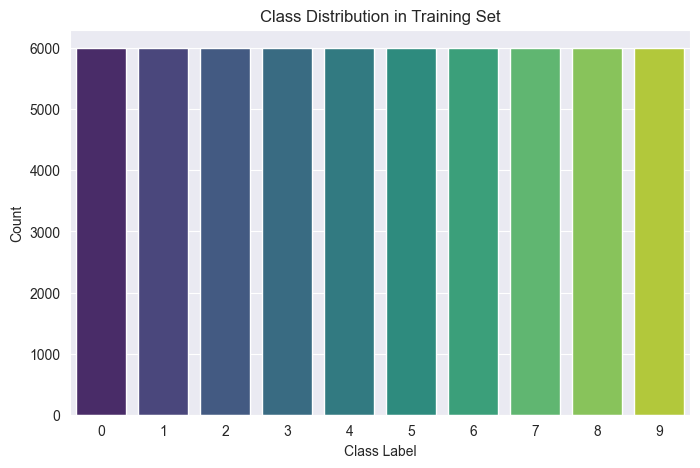

Class counts:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Is dataset imbalanced? No


In [36]:
# TODO: Analyze class distribution

plt.figure(figsize=(8, 5))
sns.countplot(x=train_df["label"], palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

class_counts = train_df["label"].value_counts().sort_index()
print("Class counts:\n", class_counts)
print("\nIs dataset imbalanced?", "Yes" if class_counts.max() / class_counts.min() > 1.5 else "No")


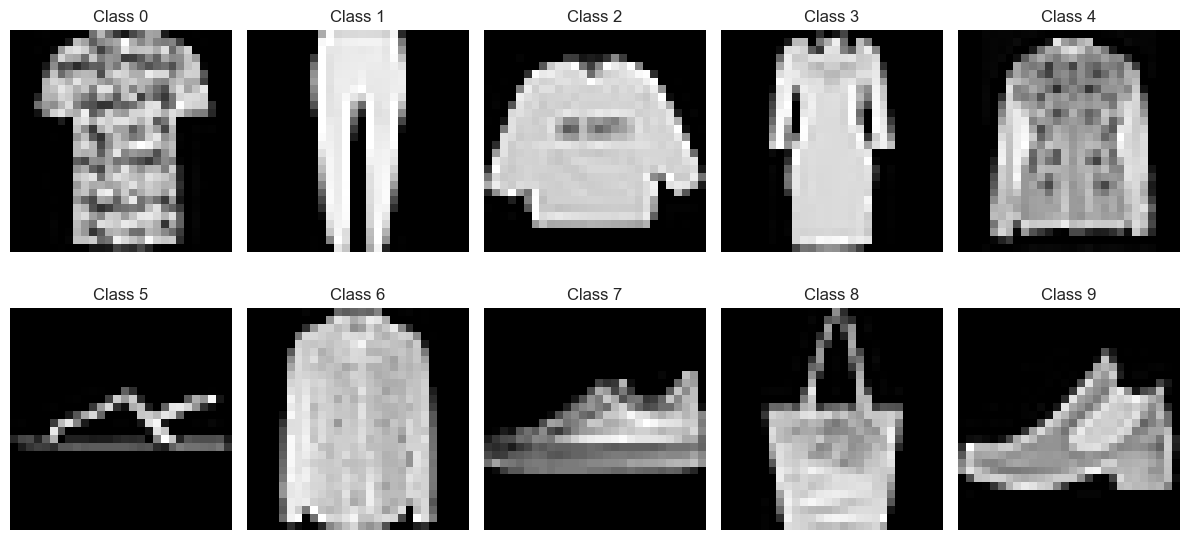

In [37]:
# TODO: Visualize sample images from each class

unique_labels = sorted(train_df["label"].unique())
num_classes = len(unique_labels)

plt.figure(figsize=(12, 6))

for idx, label in enumerate(unique_labels):
    # Find first row belonging to the label
    row = train_df[train_df["label"] == label].iloc[0, 1:]
    img = row.values.astype(np.uint8).reshape(28, 28)

    plt.subplot(2, num_classes // 2, idx + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Class {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [38]:
# TODO: Implement preprocessing pipeline

# ---- Compute mean/std for normalization ----
# Pixel values are in columns 1:785 (0-255)
all_pixels = []

for idx in tqdm(range(len(train_df)), desc="Computing mean/std"):
    row = train_df.iloc[idx, 1:].values.astype(np.float32) / 255.0
    all_pixels.append(row)

all_pixels = np.concatenate(all_pixels)
mean = float(all_pixels.mean())
std = float(all_pixels.std())

print("Dataset mean:", mean)
print("Dataset std:", std)


# ---- Preprocessing pipeline for pretrained models ----
preprocess_transform = transforms.Compose([
    # raw numpy array → PIL image
    transforms.ToPILImage(),
    # convert 1-channel grayscale → 3-channel RGB
    transforms.Grayscale(num_output_channels=3),
    # resize to ImageNet pretrained model size
    transforms.Resize((224, 224)),
    # convert to PyTorch tensor in [0,1]
    transforms.ToTensor(),
    # normalize using computed dataset stats
    transforms.Normalize(mean=[mean, mean, mean],   # 3 channels
                         std=[std, std, std])
])

print("Preprocessing pipeline created successfully.")


Computing mean/std: 100%|██████████| 60000/60000 [00:01<00:00, 37736.37it/s]


Dataset mean: 0.2861054539680481
Dataset std: 0.35281139612197876
Preprocessing pipeline created successfully.


In [39]:
# TODO: Create train/validation/test splits

# 70 / 15 / 15 split
train_df_split, val_test_df = train_test_split(
    train_df, test_size=0.30, stratify=train_df["label"], random_state=42
)

val_df, test_df_split = train_test_split(
    val_test_df, test_size=0.50, stratify=val_test_df["label"], random_state=42
)

print("Train samples:", len(train_df_split))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df_split))


Train samples: 42000
Validation samples: 9000
Test samples: 9000


In [40]:
# TODO: Implement custom Dataset class

class FashionMNISTCSV(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx].values.astype(np.uint8)

        label = int(row[0])
        img = row[1:].reshape(28, 28)  # original resolution

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0

        return img, label


In [41]:
# TODO: Create DataLoaders for train/validation/test

batch_size = 64

train_dataset = FashionMNISTCSV(train_df_split, transform=preprocess_transform)
val_dataset = FashionMNISTCSV(val_df, transform=preprocess_transform)
test_dataset = FashionMNISTCSV(test_df_split, transform=preprocess_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dataloaders created.")


Dataloaders created.


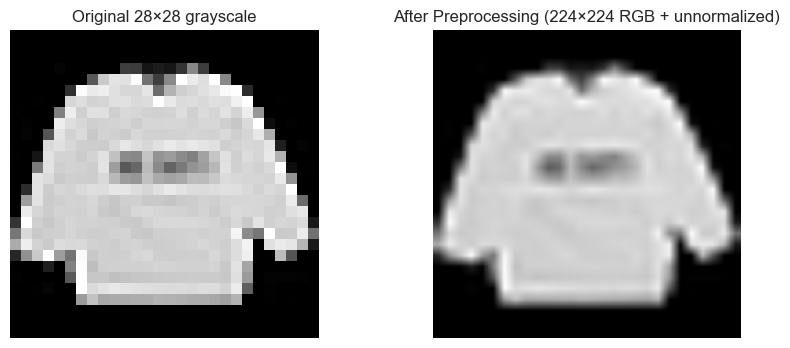

In [42]:
# TODO: Visualize preprocessing pipeline: show before/after normalization
sample_row = train_df.iloc[0, 1:].values.astype(np.uint8)
original_img = sample_row.reshape(28, 28)

# Apply preprocessing
processed_img = preprocess_transform(original_img)

# Convert C×H×W → H×W×C for matplotlib
processed_img_np = processed_img.permute(1, 2, 0).numpy()

# Un-normalize for visualization
processed_img_np = processed_img_np * std + mean
processed_img_np = np.clip(processed_img_np, 0, 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original 28×28 grayscale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed_img_np)
plt.title("After Preprocessing (224×224 RGB + unnormalized)")
plt.axis("off")

plt.show()
